In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import astropy.constants as const
import os, sys, time
import astropy.units as u
from fractions import Fraction

In [3]:
rc('text',usetex=True)
rc('font',**{'family':'serif','serif':['Times New Roman'],'size':14})#,'weight':'bold'})

# Directory Names

In [5]:
current_path = os.getcwd()
splt_path = current_path.split("/")
top_path_idx = splt_path.index('gwent')
top_directory = "/".join(splt_path[0:top_path_idx+1])

load_directory = top_directory + '/docs/LoadFiles/InstrumentFiles/'

sys.path.insert(0,top_directory + '/gwent')
import binary
import detector
import snr
import snrplot

# Constants and Initial Parameters

In [6]:
'''
Variables: 
    GLOBAL:
        'T_obs' - Observation Time
    SOURCE:
        'M' - Mass (Solar Units)
        'q' - Mass Ratio
        'chi1' - Spin1
        'chi2' - Spin2
        'z' - Redshift
    LISA ONLY:
        'L' - Armlength
        'A_acc' - Acceleration Noise
        'A_IMS' - Optical Metrology
        'f_acc_break_low'
        'f_acc_break_high'
        'f_IMS_break'
    PTAs ONLY:
        'N_p' - Number of Pulsars
        'sigma' - Timing Error RMS
        'cadence' - cadence
'''

var_y = 'z' #Variable on y-axis

sampleRate_y = 50 #Number of SNRMatrix rows

var_x = 'M' #Variable on x-axis

sampleRate_x = 50 #Number of SNRMatrix columns

In [7]:
#Selects which noise curve:
#							0 is Einstein Telescope, 
#							1 is aLIGO, 
#							2 is NANOGrav 15yr,
#							3 is SKA (2030s),
#							4 is Neil Cornish's,
#							anything else is the L3 proposal

# Source Selection

In [8]:
def Get_Source(model):
    if model == 0 or model == 1:
        #M = m1+m2 Total Mass
        M = 1e2
        M_min = 1e0
        M_max = 1e5
    elif model == 2 or model == 3:
        #M = m1+m2 Total Mass
        M = 1e8
        M_min = 1e7
        M_max = 1e11
    else:
        #M = m1+m2 Total Mass
        M = 1e6
        M_min = 1e1
        M_max = 1e10
        
    #q = m2/m1 reduced mass
    q = 1.0
    q_min = 1.0
    q_max = 18.0

    #Chi = S_i*L/m_i**2, spins of each mass i
    chi1 = 0.0 #spin of m1
    chi2 = 0.0 #spin of m2
    chi_min = -0.85 #Limits of PhenomD for unaligned spins
    chi_max = 0.85
    
    z = 3.0 #Redshift
    z_min = 1e-2
    z_max = 1e3
    
    #Doesn't Really work yet
    inc = 0.0
    inc_min = 0.0
    inc_max = 0.0
    
    source = binary.BBHFrequencyDomain(M,q,chi1,chi2,z,inc)
    source.M = [M,M_min,M_max]
    source.q = [q,q_min,q_max]
    source.chi1 = [chi1,chi_min,chi_max]
    source.chi2 = [chi2,chi_min,chi_max]
    source.z = [z,z_min,z_max]
    source.inc = [inc,inc_min,inc_max]

    return source

# Model Selection

In [13]:
def Get_Instrument(model):
    if model == 0: #Einstein Telescope
        load_name = 'ET_D_data.txt'
        load_location = load_directory + 'EinsteinTelescope/StrainFiles/' + load_name
        
        T_obs = 4*u.yr #Observing time in years
        T_obs_min = 1*u.yr
        T_obs_max = 10*u.yr
        
        instrument = detector.GroundBased('ET',T_obs,load_location=load_location,I_type='A')
        instrument.T_obs = [T_obs,T_obs_min,T_obs_max]

    elif model == 1: #aLIGO
        load_name = 'aLIGODesign.txt'
        load_location = load_directory + 'aLIGO/StrainFiles/' + load_name
        
        T_obs = 4*u.yr #Observing time in years
        T_obs_min = 1*u.yr
        T_obs_max = 10*u.yr

        instrument = detector.GroundBased('aLIGO',T_obs,load_location=load_location,I_type='A')
        instrument.T_obs = [T_obs,T_obs_min,T_obs_max]

    elif model == 2: #NANOGrav 15 yr
        ###############################################
        #NANOGrav calculation using 11.5yr parameters https://arxiv.org/abs/1801.01837
        T_obs = 15*u.yr #Observing time in years
        T_obs_min = 10*u.yr
        T_obs_max = 30*u.yr

        sigma = 100*u.ns.to('s')*u.s #rms timing residuals in seconds
        
        N_p = 18 #Number of pulsars
        
        cadence = 1/(2*u.wk.to('yr')*u.yr) #Avg observation cadence of 1 every 2 weeks in num/year
        
        instrument = detector.PTA('NANOGrav',T_obs,N_p,sigma,cadence)
        instrument.T_obs = [T_obs,T_obs_min,T_obs_max]

        
    elif model == 3: #SKA (2030s)
        ###############################################
        #SKA calculation using parameters and methods from arXiv:0804.4476 section 7.1
        T_obs = 15*u.yr #Observing time (years)
        T_obs_min = 10*u.yr
        T_obs_max = 30*u.yr
        
        sigma = 10*u.ns.to('s')*u.s #rms timing residuals in nanoseconds
        
        N_p = 20 #Number of pulsars
        
        cadence = 1/(u.wk.to('yr')*u.yr) #Avg observation cadence of 1 every week in num/year
        
        instrument = detector.PTA('SKA',T_obs,N_p,sigma,cadence)
        instrument.T_obs = [T_obs,T_obs_min,T_obs_max]
        
    elif model == 4: #Robson,Cornish,and Liu 2018, LISA (https://arxiv.org/pdf/1803.01944.pdf)
        T_obs = 4*u.yr #Observing time in years
        T_obs_min = 1*u.yr
        T_obs_max = 10*u.yr

        L = 2.5e9*u.m #armlength in meters
        L_min = 1.0e7*u.m
        L_max = 1.0e11*u.m
          
        A_acc = 3e-15*u.m/u.s/u.s #M/s**2
        A_IMS = 1.5e-11*u.m
        f_IMS_break = 2.*u.mHz.to('Hz')*u.Hz
        f_acc_break_low = .4*u.mHz.to('Hz')*u.Hz
        f_acc_break_high = 8.*u.mHz.to('Hz')*u.Hz
        Background = False
        
        instrument = detector.SpaceBased('Neil_LISA',\
                                       T_obs,L,A_acc,f_acc_break_low,f_acc_break_high,A_IMS,f_IMS_break,\
                                       Background=Background)
        instrument.T_obs = [T_obs,T_obs_min,T_obs_max]
        instrument.L = [L,L_min,L_max]
        
    else: #L3 proposal
        #Default Params!
        T_obs = 4*u.yr #Observing time in years
        T_obs_min = 1*u.yr
        T_obs_max = 10*u.yr
        
        L = 2.5e9*u.m #armlength in meters
        L_min = 1.0e7*u.m
        L_max = 1.0e11*u.m
        
        f_acc_break_low = .4*u.mHz.to('Hz')*u.Hz
        f_acc_break_high = 8.*u.mHz.to('Hz')*u.Hz
        f_IMS_break = 2.*u.mHz.to('Hz')*u.Hz
        A_acc = 3e-15*u.m/u.s/u.s
        A_IMS = 10e-12*u.m
        Background = False
        
        instrument = detector.SpaceBased('LISA_ESA',\
                                       T_obs,L,A_acc,f_acc_break_low,f_acc_break_high,A_IMS,f_IMS_break,\
                                       Background=Background)
        instrument.T_obs = [T_obs,T_obs_min,T_obs_max]
        instrument.L = [L,L_min,L_max]
        
    return instrument

# Setting Up SNR Calculation
Uses the variables given and the data range to sample the space either logrithmically or linearly based on the 
selection of variables. Then it computes the SNR for each value.
Returns the variable ranges used to calculate the SNR for each matrix, then returns the SNRs with size of the sample1Xsample2


In [14]:
model = 2
instrument = Get_Instrument(model)
source = Get_Source(model)
start = time.time()
[sample_x,sample_y,SNRMatrix] = snr.Get_SNR_Matrix(source,instrument,\
                                                 var_x,sampleRate_x,var_y,sampleRate_y)
end = time.time()
print(end-start)

13.84812593460083


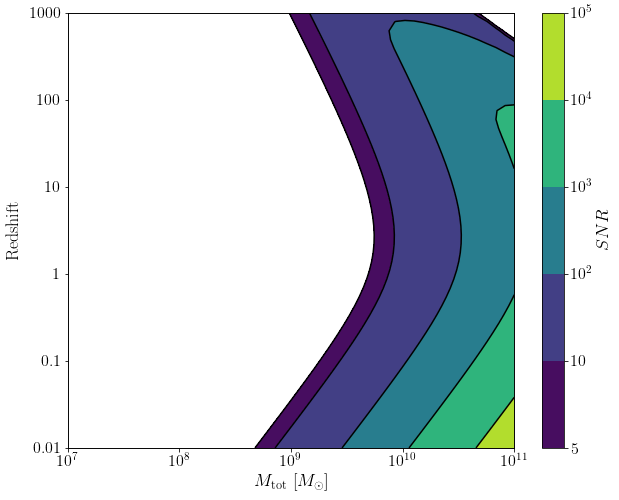

In [15]:
snrplot.Plot_SNR(source,instrument,var_x,sample_x,var_y,sample_y,SNRMatrix,smooth_contours=False)

# Whole Hog Creation of SNR Matrices and Samples

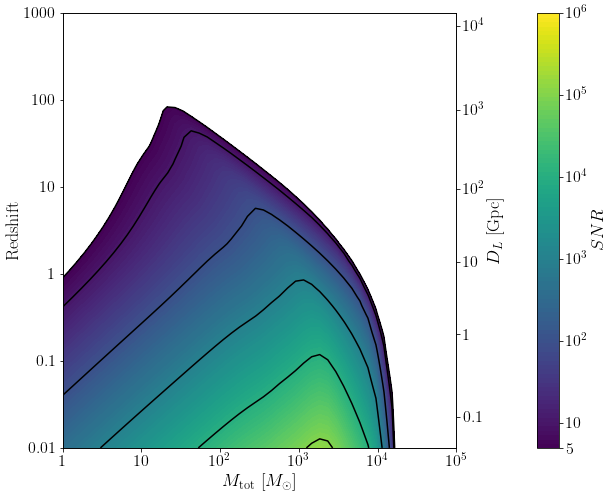

Model:  ET ,  done. t = :  16.091941833496094


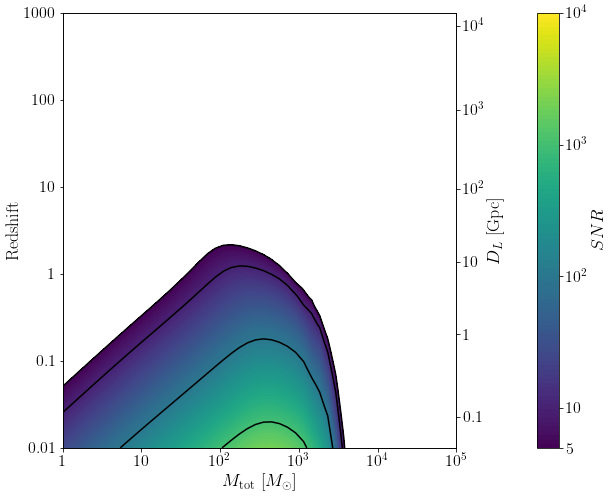

Model:  aLIGO ,  done. t = :  16.612098693847656


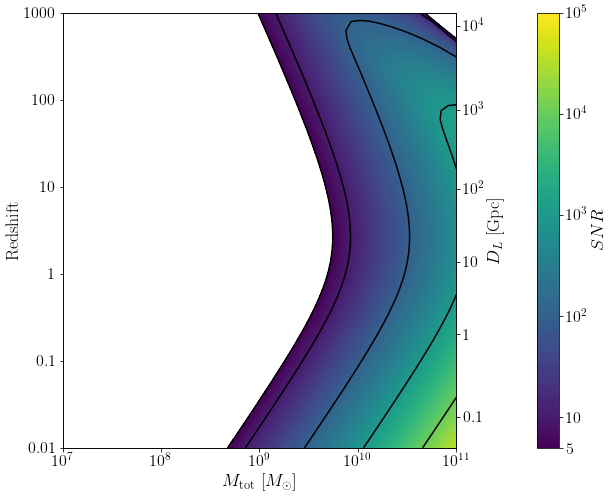

Model:  NANOGrav ,  done. t = :  14.794465065002441


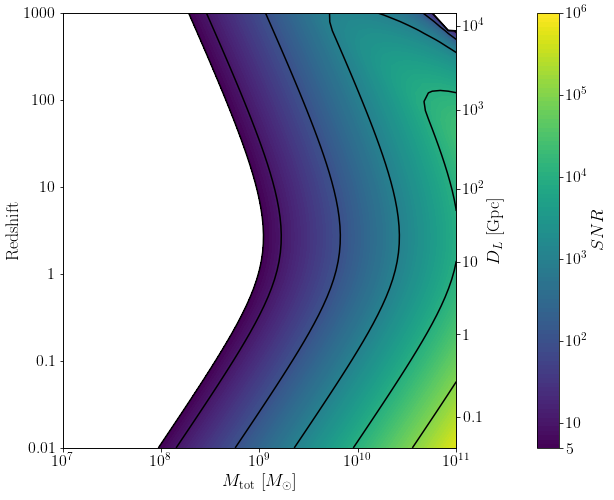

Model:  SKA ,  done. t = :  21.330587148666382


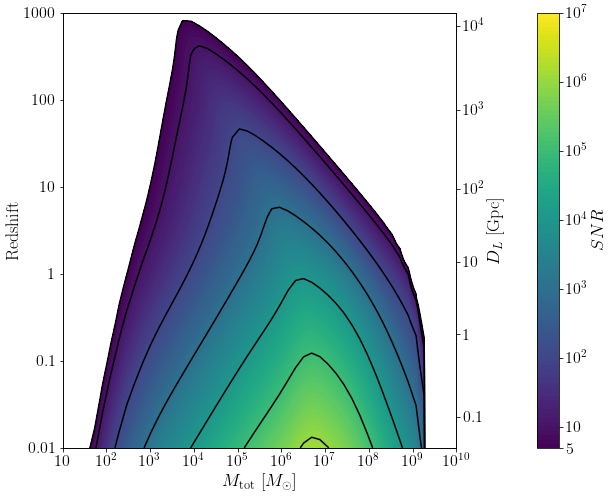

Model:  Neil_LISA ,  done. t = :  17.32237696647644


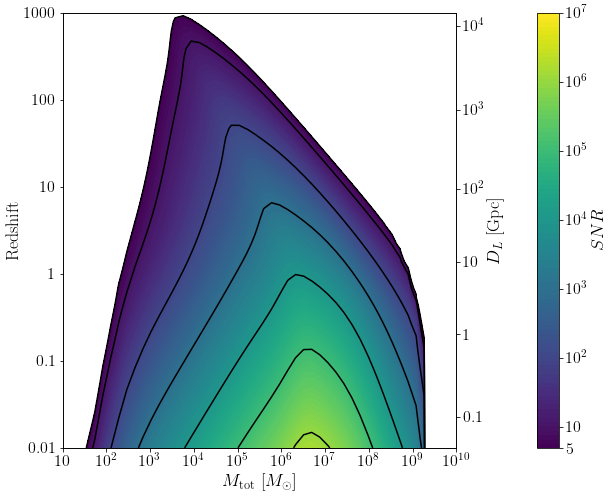

Model:  LISA_ESA ,  done. t = :  17.09630513191223


In [17]:
models = [0,1,2,3,4,5]
for model in models:
    instrument = Get_Instrument(model)
    source = Get_Source(model)
    start = time.time()
    [sample_x,sample_y,SNRMatrix] = snr.Get_SNR_Matrix(source,instrument,\
                                             var_x,sampleRate_x,var_y,sampleRate_y)
    end = time.time()
    #snr.Save_SNR(sample_x,sample_y,SNRMatrix,save_location,SNR_save_name,Sample_save_name)
    snrplot.Plot_SNR(source,instrument,var_x,sample_x,var_y,sample_y,SNRMatrix,dl_axis=True,smooth_contours=True)
    print('Model: ',instrument.name,',',' done. t = : ',end-start)